# Bank Customer Churn


## Data Background

This dataset can be found [here](https://www.kaggle.com/datasets/gauravtopre/bank-customer-churn-dataset) on kaggle.com.  It appears to be fictitious data created for a ML classification exercise

## Data Dictionary


* **customer_id** - unused variable.
* **credit_score** - 
* **country** - 
* **gender** - 'Male' or 'Female'
* **age** - 
* **tenure** - assuming years with as customer
* **balance** - 
* **products_number** - assuming number of bank products used (e.g. credit, home loan, checking acct., etc.)
* **credit_card** - 1 or 0
* **active_member** - 1 or 0
* **estimated_salary** - 
* **churn** - used as the target. 1 if the client has left the bank during some period or 0 if he/she has not.

## Imports

In [68]:
# Analysis, Visualization
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px
# DBMS
import duckdb
# ML
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import (ColumnTransformer, make_column_transformer,
                             make_column_selector)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import (train_test_split, GridSearchCV,
                                     RandomizedSearchCV)
# Models
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
# Metrics
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             classification_report, ConfusionMatrixDisplay,
                            silhouette_score)
# Settings
pd.set_option('display.float_format', '{:.2f}'.format)

## Database Creation, Loading Data

In [4]:
# creating connection to database
conn = duckdb.connect('churn_data.db')

In [5]:
# creating a df frame
df = conn.execute('''
from 'Bank Customer Churn Prediction.csv'
''').df()

## DuckDB Exploration

In [6]:
# duckdb accepts bare from statements
duckdf = conn.execute('''
from
'Bank Customer Churn Prediction.csv'
''').df()

# converting to view to see data types, cannot use on bare query
conn.register('duckdf_view', duckdf)
conn.execute('describe duckdf_view').df()

column_name column_type null  key default  extra
0        customer_id      BIGINT  YES  NaN     NaN    NaN
1       credit_score      BIGINT  YES  NaN     NaN    NaN
2            country     VARCHAR  YES  NaN     NaN    NaN
3             gender     VARCHAR  YES  NaN     NaN    NaN
4                age      BIGINT  YES  NaN     NaN    NaN
5             tenure      BIGINT  YES  NaN     NaN    NaN
6            balance      DOUBLE  YES  NaN     NaN    NaN
7    products_number      BIGINT  YES  NaN     NaN    NaN
8        credit_card      BIGINT  YES  NaN     NaN    NaN
9      active_member      BIGINT  YES  NaN     NaN    NaN
10  estimated_salary      DOUBLE  YES  NaN     NaN    NaN
11             churn      BIGINT  YES  NaN     NaN    NaN

<mark><u>**Comment:**</u>

<font color='dodgerblue' size=4><i>
Data types look correct.  However, we could optimize this data by converting most of the BIGINT dtypes to SMALL or TINY to save memory.  If going relational, we would want to set our primary key to customer_id
</i></font>

### Brief SQL Analysis With DuckDB

#### Where are customers most likely to churn and what do we know about their average salaries and credit scores?

In [7]:
conn.execute('''
select 
    country,
    gender,
    avg(estimated_salary) as avg_salary,
    avg(credit_score) as avg_credit_score,
    avg(age) as avg_age,
    avg(churn) as avg_churn
from 'Bank Customer Churn Prediction.csv'
group by 1, 2
order by avg_churn desc
''').df()

country  gender  avg_salary  avg_credit_score  avg_age  avg_churn
0  Germany  Female   102446.42            653.09    40.15       0.38
1  Germany    Male    99905.03            649.97    39.42       0.28
2    Spain  Female   100734.11            651.77    39.20       0.21
3   France  Female    99564.25            649.19    38.77       0.20
4    Spain    Male    98425.69            650.99    38.65       0.13
5   France    Male   100174.25            650.06    38.30       0.13

<mark><u>**Comment:**</u>

<font color='dodgerblue' size=4><i>
It seems that we have more customers churning from Germany, let's find out if that is simply due to distribution of countries in our data.  The ages, credit scores and salaries look similar enough that there may be something else happening.
</i></font>

In [8]:
# duck db supports group by all syntax
conn.execute('''
select
    country,
    count(distinct customer_id) as n_customers,
    avg(churn) as avg_churn
from 'Bank Customer Churn Prediction.csv'
group by all
''').df()

country  n_customers  avg_churn
0   France         5014       0.16
1    Spain         2477       0.17
2  Germany         2509       0.32

<mark><u>**Comment:**</u>

<font color='dodgerblue' size=4><i>
This leads me to believe we have a sampling error inherent in the data, or we have many more customers churning from Germany as from France and Spain.
</i></font>

#### Top earners in each country

In [9]:
conn.execute('''
with cte as
    (select country,
            estimated_salary,
            rank() over(
            partition by country order by estimated_salary desc) as salary_rank
    from 'Bank Customer Churn Prediction.csv')
select *
from cte
where salary_rank <=5
''').df()

country  estimated_salary  salary_rank
0   Germany         199970.74            1
1   Germany         199808.10            2
2   Germany         199805.63            3
3   Germany         199761.29            4
4   Germany         199725.39            5
5     Spain         199992.48            1
6     Spain         199953.33            2
7     Spain         199857.47            3
8     Spain         199753.97            4
9     Spain         199505.53            5
10   France         199929.17            1
11   France         199909.32            2
12   France         199862.75            3
13   France         199841.32            4
14   France         199775.67            5

<mark><u>**Comment:**</u>

<font color='dodgerblue' size=4><i>
These results lead me to think that this dataset had a salary cap at $200,000
</i></font>

## Viewing Data

In [10]:
df.sample(5)

customer_id  credit_score  country  gender  age  tenure   balance  \
7735     15774936           543  Germany    Male   41       6 143350.41   
1611     15781553           760  Germany  Female   49       9  91502.99   
4719     15583580           566  Germany  Female   35       1 123042.00   
5505     15802466           534   France  Female   53       7      0.00   
2404     15809286           631  Germany    Male   37       8 138292.64   

      products_number  credit_card  active_member  estimated_salary  churn  
7735                1            1              1         192070.16      1  
1611                1            1              0         117232.90      1  
4719                1            1              0          66245.44      1  
5505                2            1              1          80619.17      0  
2404                2            0              0         152422.91      1

In [11]:
display(df.describe(include='all').T, df.info(), df.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       10000 non-null  int64  
 1   credit_score      10000 non-null  int64  
 2   country           10000 non-null  object 
 3   gender            10000 non-null  object 
 4   age               10000 non-null  int64  
 5   tenure            10000 non-null  int64  
 6   balance           10000 non-null  float64
 7   products_number   10000 non-null  int64  
 8   credit_card       10000 non-null  int64  
 9   active_member     10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


count unique     top  freq        mean      std  \
customer_id      10000.00    NaN     NaN   NaN 15690940.57 71936.19   
credit_score     10000.00    NaN     NaN   NaN      650.53    96.65   
country             10000      3  France  5014         NaN      NaN   
gender              10000      2    Male  5457         NaN      NaN   
age              10000.00    NaN     NaN   NaN       38.92    10.49   
tenure           10000.00    NaN     NaN   NaN        5.01     2.89   
balance          10000.00    NaN     NaN   NaN    76485.89 62397.41   
products_number  10000.00    NaN     NaN   NaN        1.53     0.58   
credit_card      10000.00    NaN     NaN   NaN        0.71     0.46   
active_member    10000.00    NaN     NaN   NaN        0.52     0.50   
estimated_salary 10000.00    NaN     NaN   NaN   100090.24 57510.49   
churn            10000.00    NaN     NaN   NaN        0.20     0.40   

                         min         25%         50%         75%         max  
customer_id      15565701.00 15628528.25 15690738.00 15753233.75 15815690.00  
credit_score          350.00      584.00      652.00      718.00      850.00  
country                  NaN         NaN         NaN         NaN         NaN  
gender                   NaN         NaN         NaN         NaN         NaN  
age                    18.00       32.00       37.00       44.00       92.00  
tenure                  0.00        3.00        5.00        7.00       10.00  
balance                 0.00        0.00    97198.54   127644.24   250898.09  
products_number         1.00        1.00        1.00        2.00        4.00  
credit_card             0.00        0.00        1.00        1.00        1.00  
active_member           0.00        0.00        1.00        1.00        1.00  
estimated_salary       11.58    51002.11   100193.91   149388.25   199992.48  
churn                   0.00        0.00        0.00        0.00        1.00

None

Index(['customer_id', 'credit_score', 'country', 'gender', 'age', 'tenure',
       'balance', 'products_number', 'credit_card', 'active_member',
       'estimated_salary', 'churn'],
      dtype='object')

<mark><u>**Comment:**</u>

* <font color='dodgerblue' size=4><i>
    Overall this data looks pretty clean, we will still check for duplicates and NaNs, but it appears to have been pre-cleaned.
* <font color='dodgerblue' size=4><i>
    We should be able to discard customer id, but will check to make sure there are no duplicate values (customer entered in twice).
* <font color='dodgerblue' size=4><i>
    There are only 3 countries in the dataset, with France being the most frequent.  We'll have to keep this in mind when thinking of the scope of the model's usability
* <font color='dodgerblue' size=4><i>
    Most of our values are already ordinal/ohe encoded, but will have to adjust the 'gender' column.
    
</i></font>

## Cleaning

### checking for duplicates, NaNs

In [12]:
df.duplicated().sum()

0

In [13]:
df.isna().sum()

customer_id         0
credit_score        0
country             0
gender              0
age                 0
tenure              0
balance             0
products_number     0
credit_card         0
active_member       0
estimated_salary    0
churn               0
dtype: int64

In [14]:
# checking customer id column to see if there are repeated values
df['customer_id'].value_counts().max()

1

### changing 'gender' to numerical, 1=male, 0=female

In [15]:
df['gender'] = df['gender'].map({'Male': 1, 'Female': 0})

# confirming
df['gender'].value_counts()

gender
1    5457
0    4543
Name: count, dtype: int64

### checking categorical values for errors

In [16]:
for i in df.columns:
    if df[i].dtype == 'object' or df[i].nunique() <= 10:
        print(i.upper(), '\n', df[i].unique(), df[i].dtype)

COUNTRY 
 ['France' 'Spain' 'Germany'] object
GENDER 
 [0 1] int64
PRODUCTS_NUMBER 
 [1 3 2 4] int64
CREDIT_CARD 
 [1 0] int64
ACTIVE_MEMBER 
 [1 0] int64
CHURN 
 [1 0] int64


<mark><u>**Comment:**</u>

<font color='dodgerblue' size=4><i>
All looks good!
</i></font>

### rechecking dtypes

In [17]:
df.dtypes

customer_id           int64
credit_score          int64
country              object
gender                int64
age                   int64
tenure                int64
balance             float64
products_number       int64
credit_card           int64
active_member         int64
estimated_salary    float64
churn                 int64
dtype: object

### dropping 'customer_id' column

In [18]:
df = df.drop(columns='customer_id').copy()

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   credit_score      10000 non-null  int64  
 1   country           10000 non-null  object 
 2   gender            10000 non-null  int64  
 3   age               10000 non-null  int64  
 4   tenure            10000 non-null  int64  
 5   balance           10000 non-null  float64
 6   products_number   10000 non-null  int64  
 7   credit_card       10000 non-null  int64  
 8   active_member     10000 non-null  int64  
 9   estimated_salary  10000 non-null  float64
 10  churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(1)
memory usage: 859.5+ KB


## EDA

### Brief Overview of data visualized

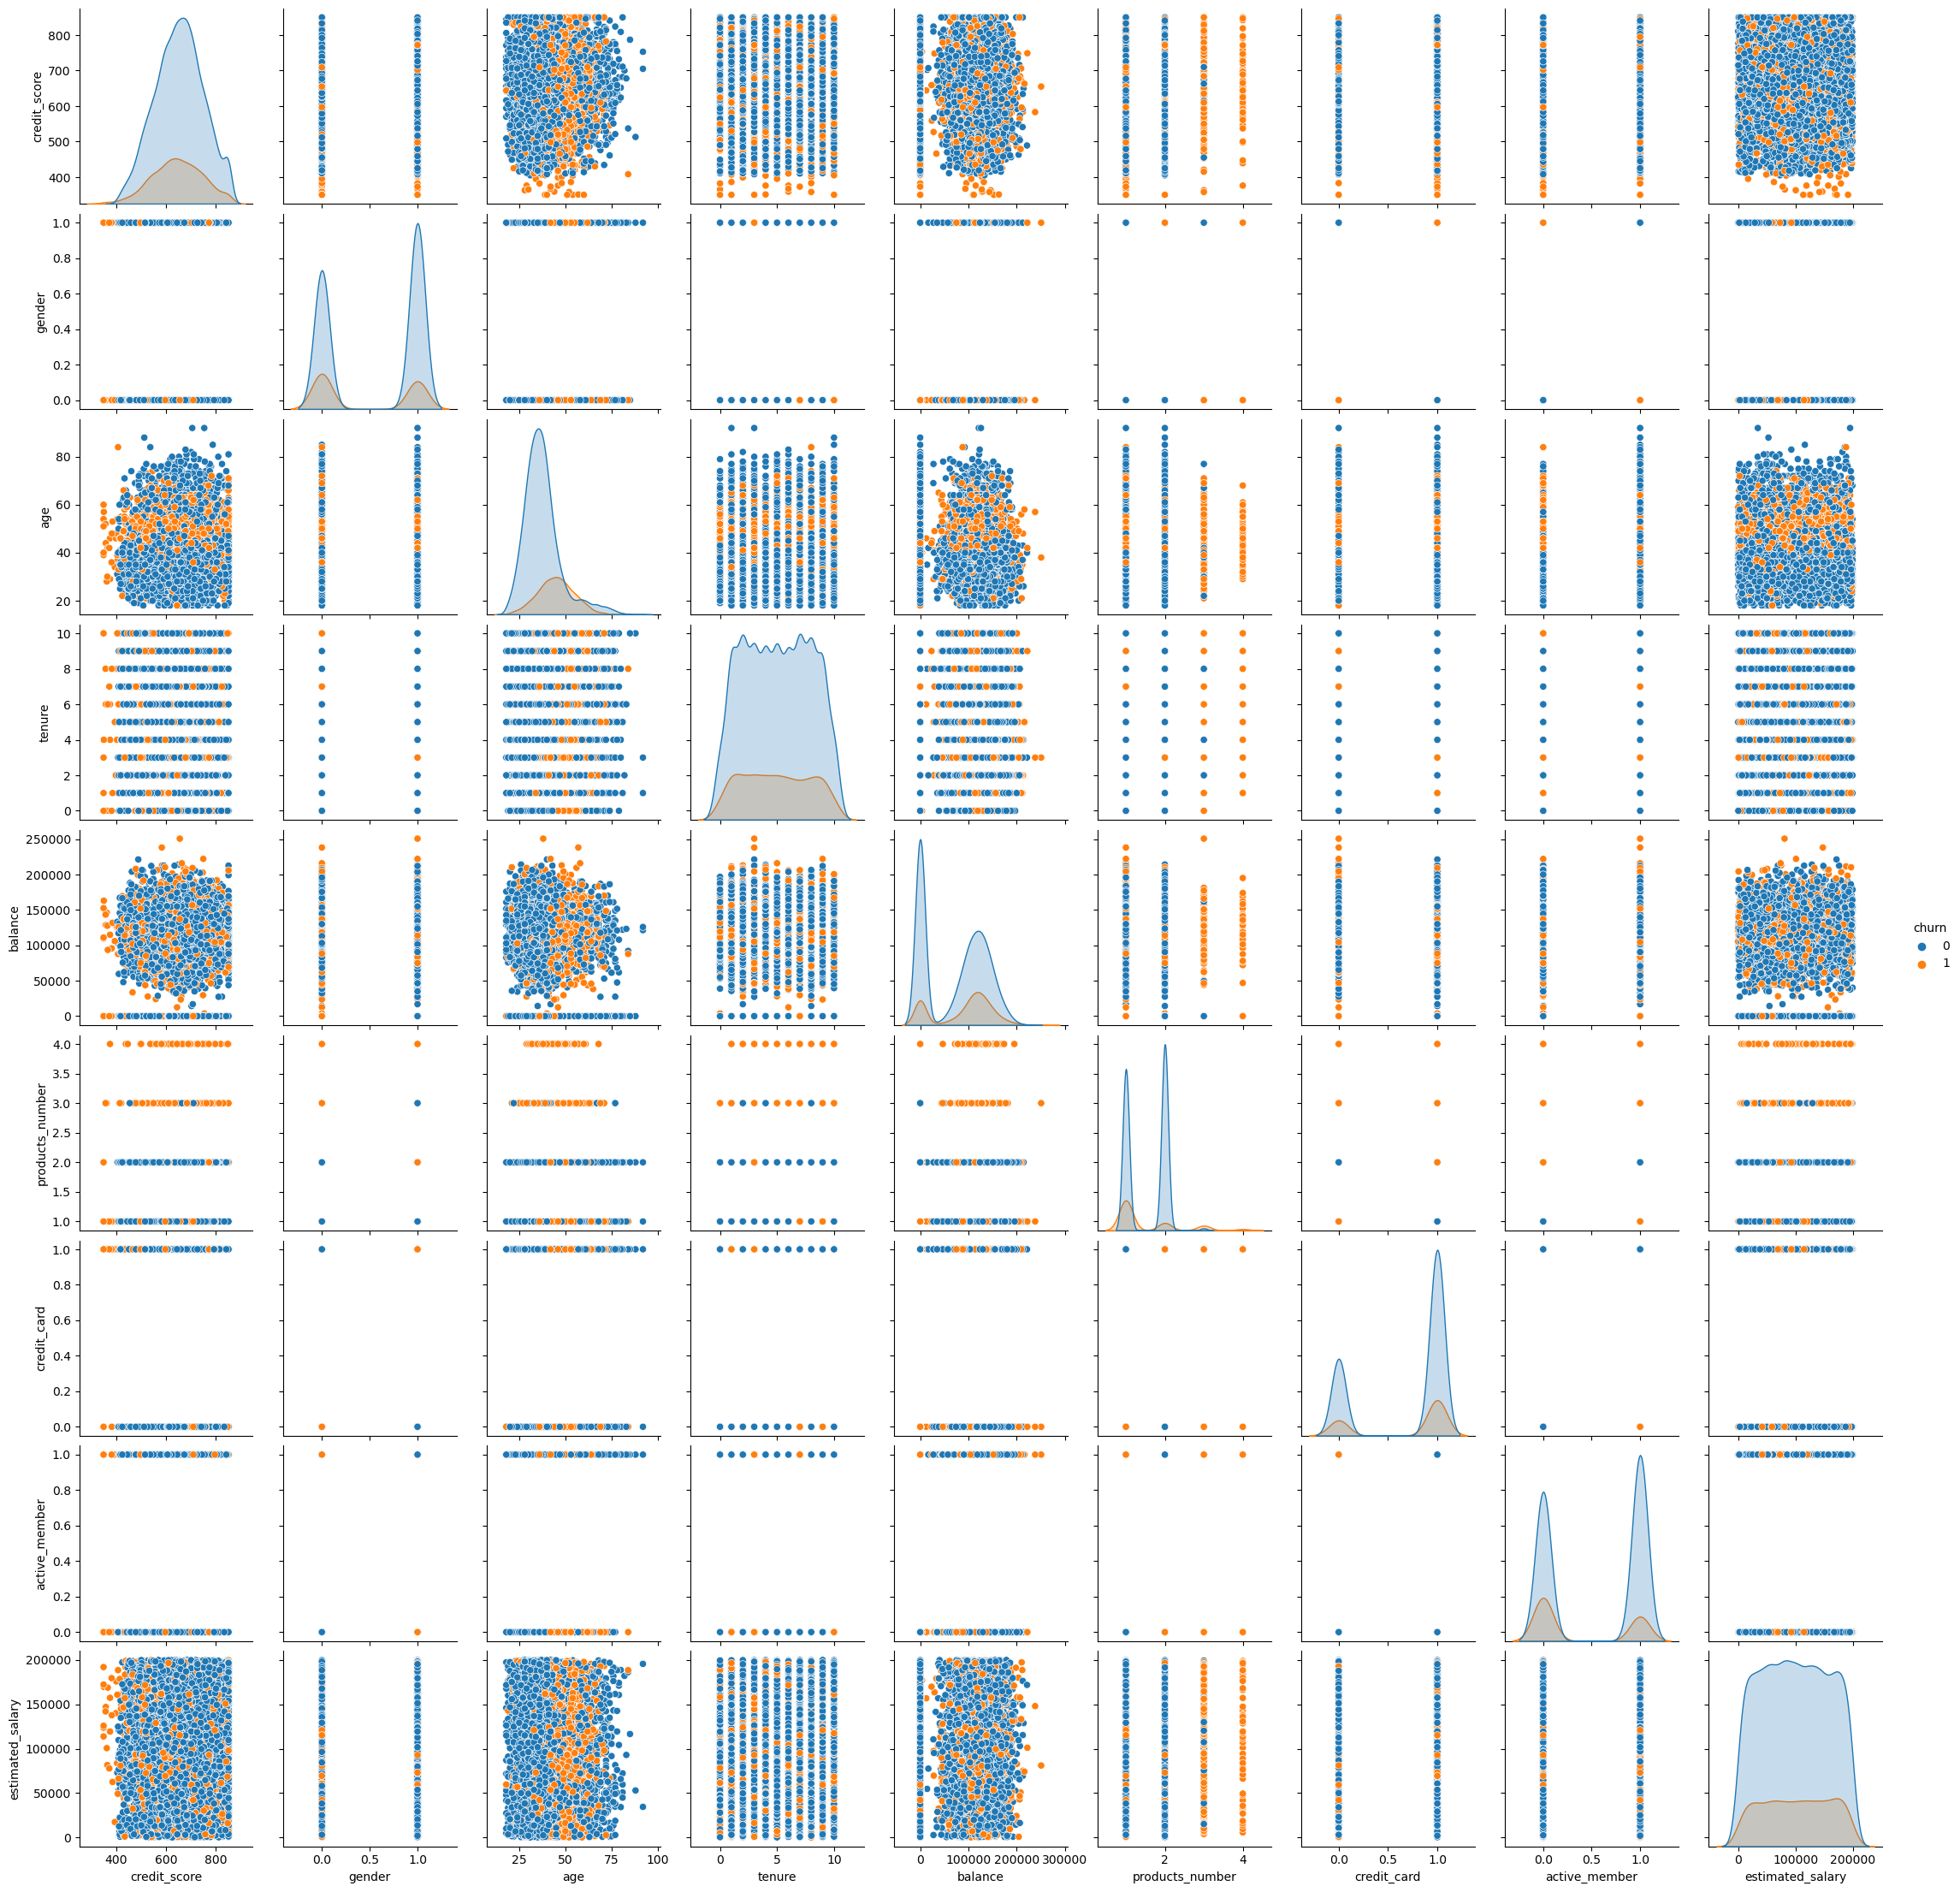

In [19]:
sns.pairplot(data=df, hue='churn');

<mark><u>**Comment:**</u>

<font color='dodgerblue' size=4><i>
It appears there are features in this dataset which should help the models differentiate churned customers.  'age', 'estimated salary', and 'number of products' seem to be the most likely candidates.  There is an interesting band of churned customers between ages 45-75 that I'd like to explore.
</i></font>

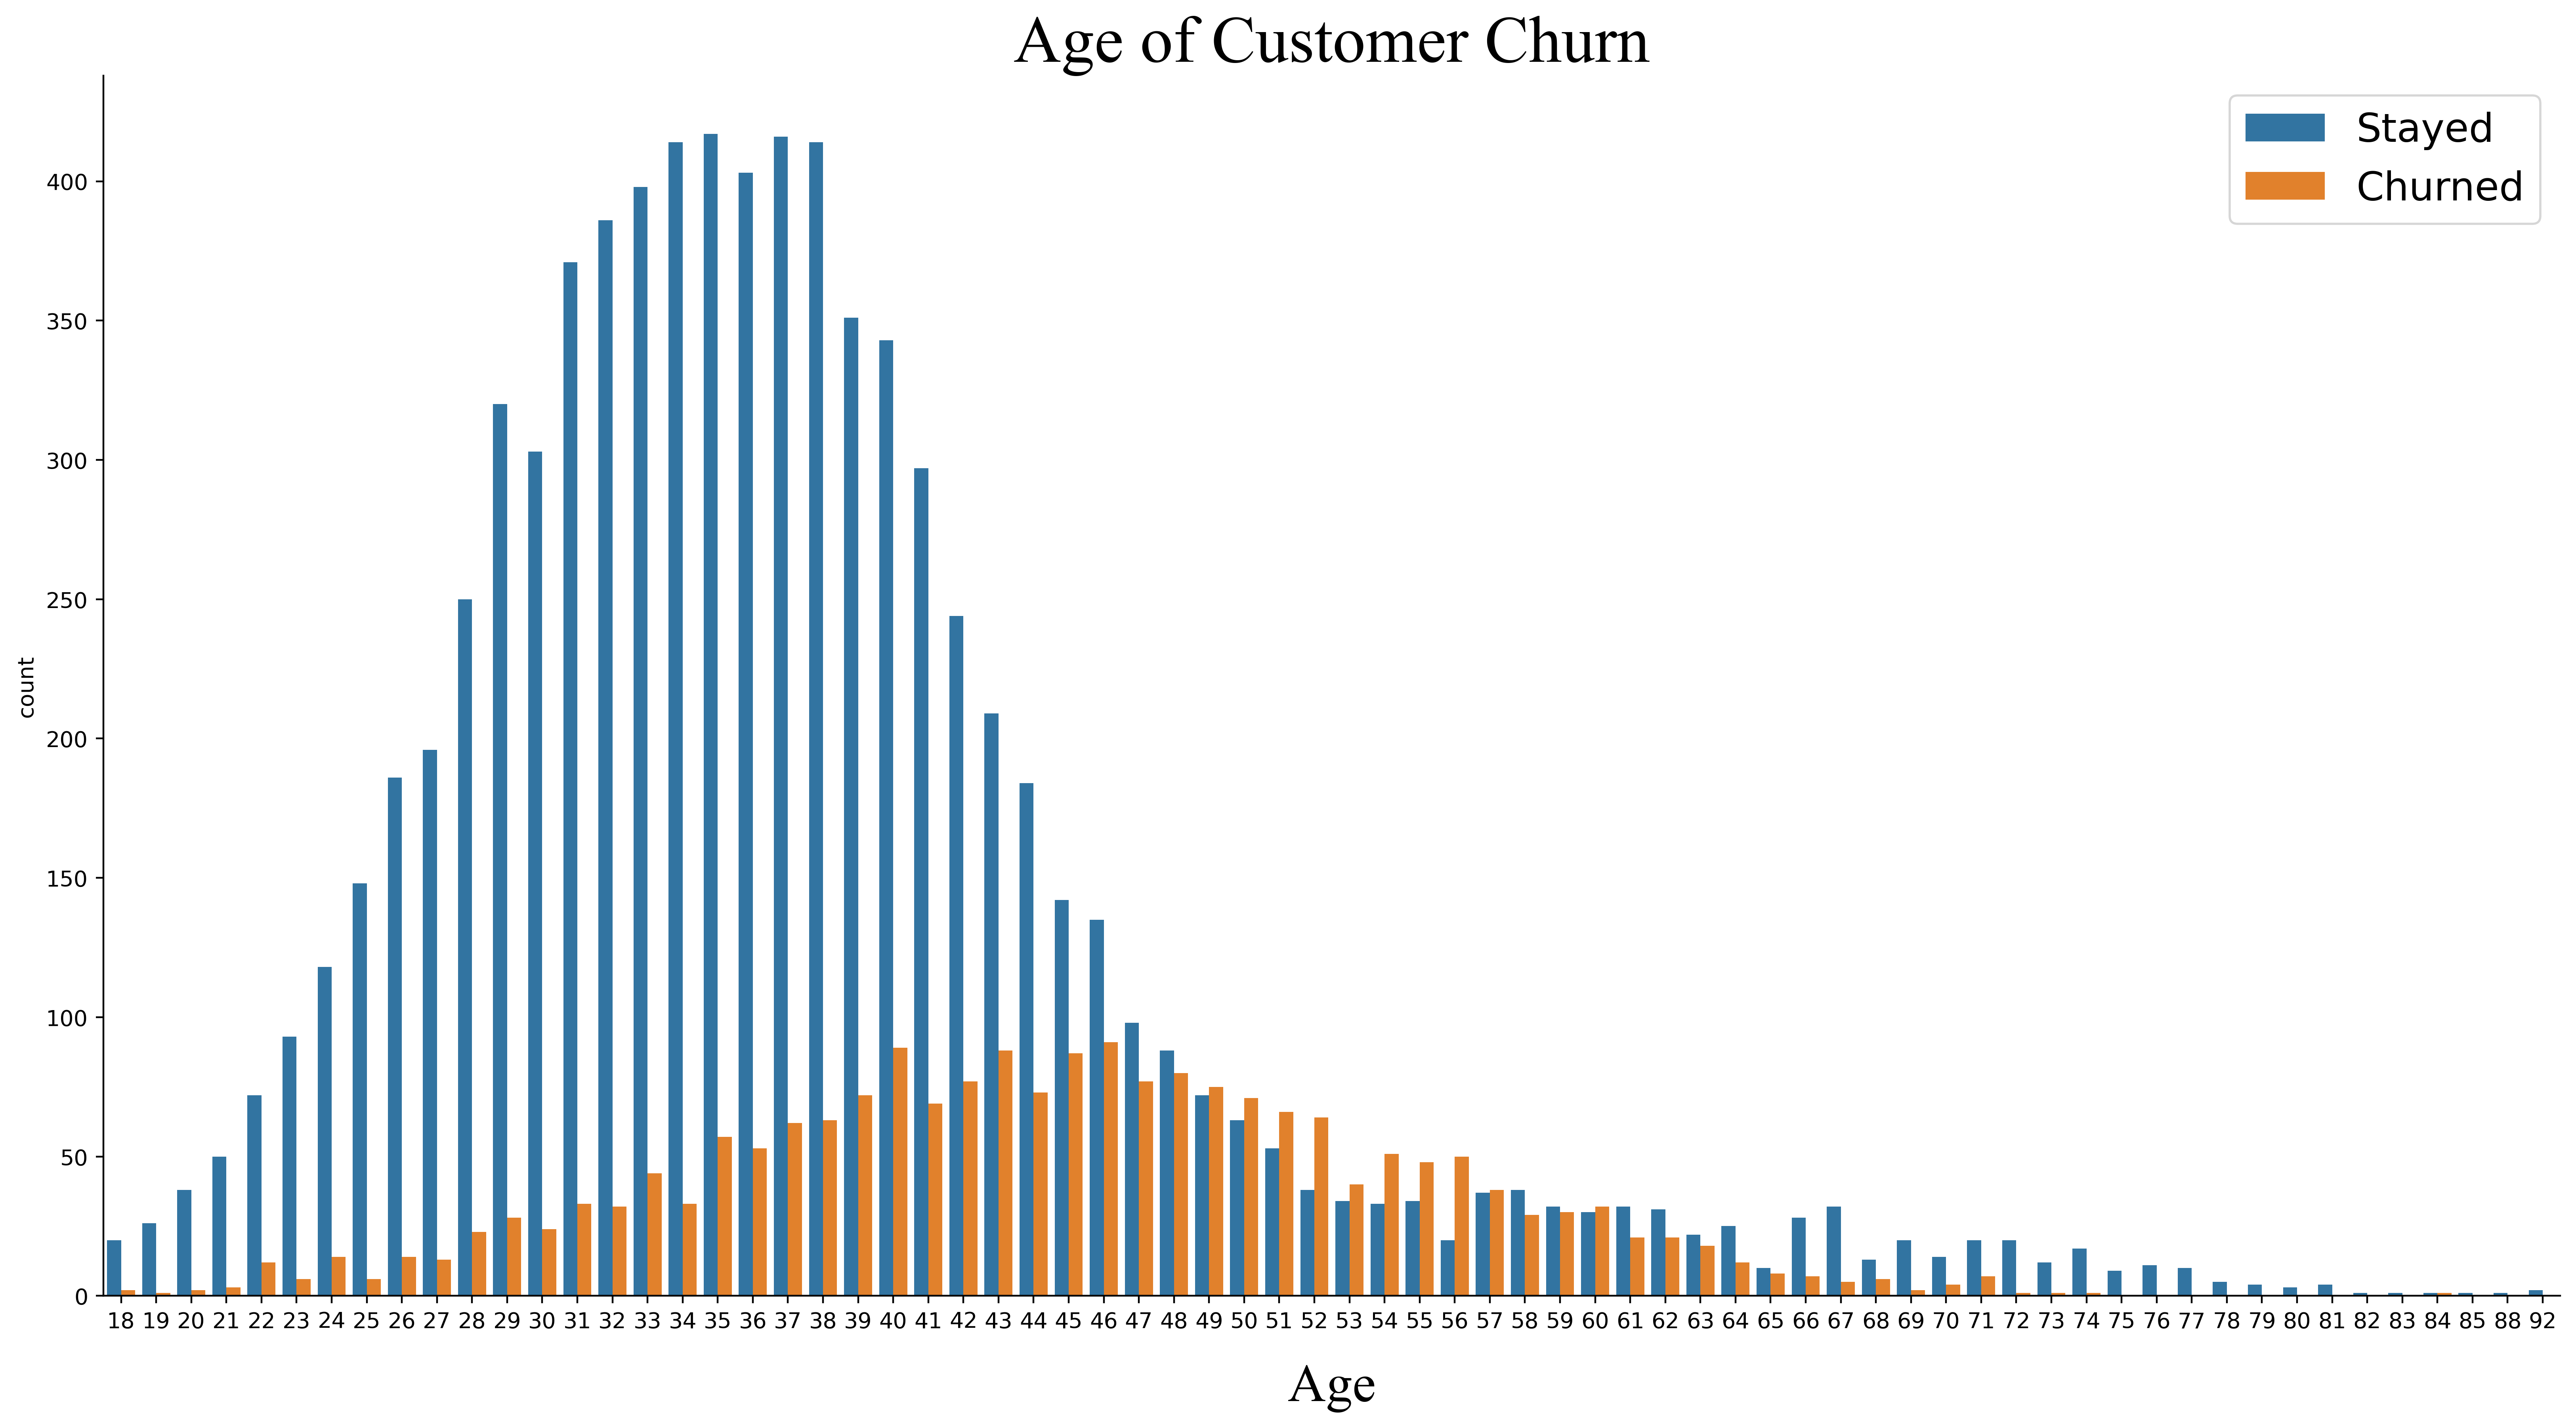

In [20]:
# exploring age of churn
plt.figure(figsize=(20,10), dpi=400)
ax = plt.gca()
sns.countplot(data=df, x='age', hue='churn')
plt.title('Age of Customer Churn', font={'size':30, 'family':'Times New Roman'})
ax.spines[['top', 'right']].set_visible(False)
plt.xlabel('Age', fontsize=24, labelpad=14, fontfamily='Times New Roman')
plt.legend(labels= ['Stayed', 'Churned'], fontsize=18);

<mark><u>**Comment:**</u>

<font color='dodgerblue' size=4><i>
Here's what I would speculate is going on here:  As customers accrue more wealth going in to middle age, they have more capital to use and various financial products become more relevant to them.  This results in seeking more competitive offers on financial instruments, increasing their likelihood of churning.  In their 20's and early 30's, they're more likely to have little capital to work with, so they may be more likely to keep the same bank, only utilizing savings/checking options.
</i></font>

## Cluster Analysis

In [61]:
# dropping our non-numerical column 'country'
df_mod = df.drop(columns='country')

In [62]:
df_scale = StandardScaler().fit_transform(df_mod)

In [84]:
# trying different numbers of clusters, saving to a list, and plotting
sils = []
inertias = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(df_scale)
    inertias.append(kmeans.inertia_)
    sils.append(silhouette_score(df_scale, kmeans.labels_))

Text(0.5, 1.0, 'Silhouette Scores')

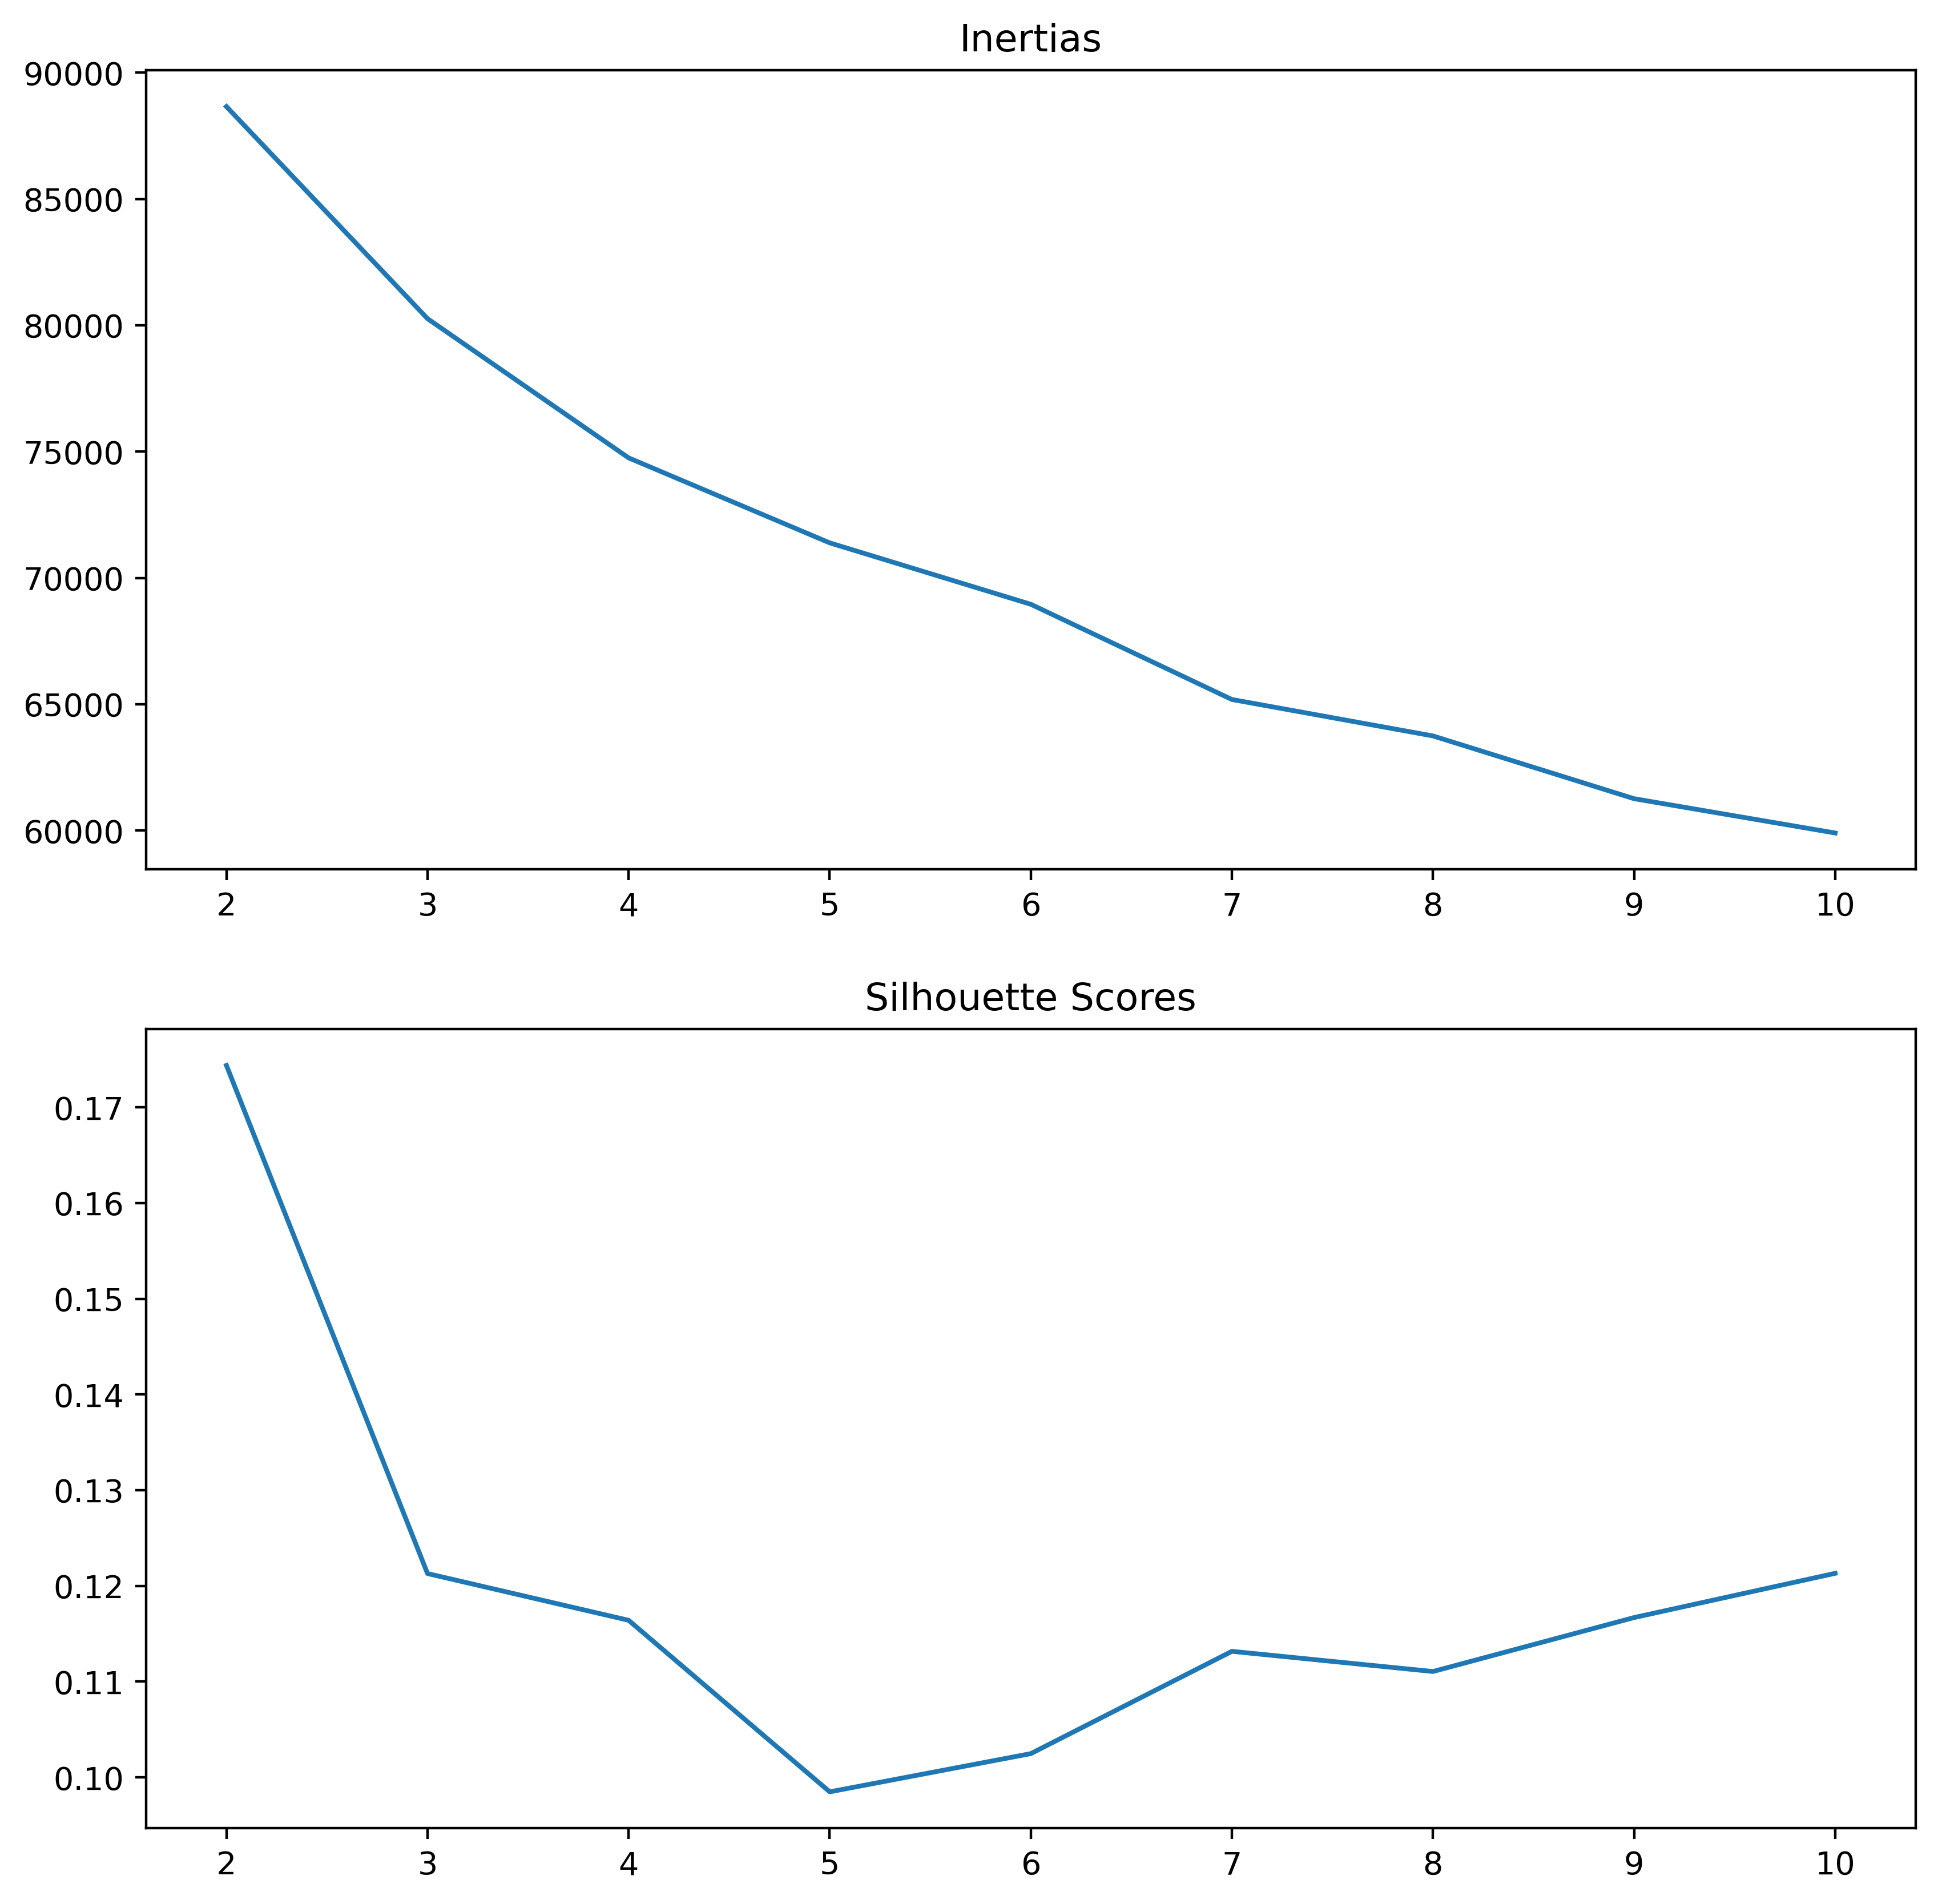

In [86]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10,10), dpi=400)
plt.subplots_adjust(hspace=.2)
sns.lineplot(x=range(2,11), y=inertias, ax=ax1)
sns.lineplot(x=range(2,11), y=sils, ax=ax2)
ax1.set_title('Inertias')
ax2.set_title('Silhouette Scores')

<mark><u>**Comment:**</u>

<font color='dodgerblue' size=4><i>
Not seeing a distinct elbow here for guidance, maybe at 4?  We seem to have our highest value at 3 clusters and then the scores seem to drop off.
</i></font>

In [88]:
# fresh copy to avoid corrupting other dfs
df_cl = df.copy()

# creating the model, fitting
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(df_scale)

# adding the label to the df
df_cl['cluster'] = kmeans.labels_

# confirming
df_cl.head()

credit_score country  gender  age  tenure   balance  products_number  \
0           619  France       0   42       2      0.00                1   
1           608   Spain       0   41       1  83807.86                1   
2           502  France       0   42       8 159660.80                3   
3           699  France       0   39       1      0.00                2   
4           850   Spain       0   43       2 125510.82                1   

   credit_card  active_member  estimated_salary  churn  cluster  
0            1              1         101348.88      1        1  
1            0              1         112542.58      0        2  
2            1              0         113931.57      1        1  
3            0              0          93826.63      0        0  
4            1              1          79084.10      0        2

In [100]:
# dropping 'country' because it is an object dtype
clusters = df_cl.drop(columns='country').groupby('cluster').mean().reset_index()
clusters

cluster  credit_score  gender   age  tenure   balance  products_number  \
0        0        650.58    0.56 37.39    5.11   4953.67             1.85   
1        1        645.33    0.44 44.93    4.93  92103.27             1.45   
2        2        652.77    0.58 37.42    4.98 122054.07             1.33   

   credit_card  active_member  estimated_salary  churn  
0         0.72           0.54          98568.95   0.01  
1         0.70           0.36         101353.22   1.00  
2         0.70           0.56         100652.40   0.00

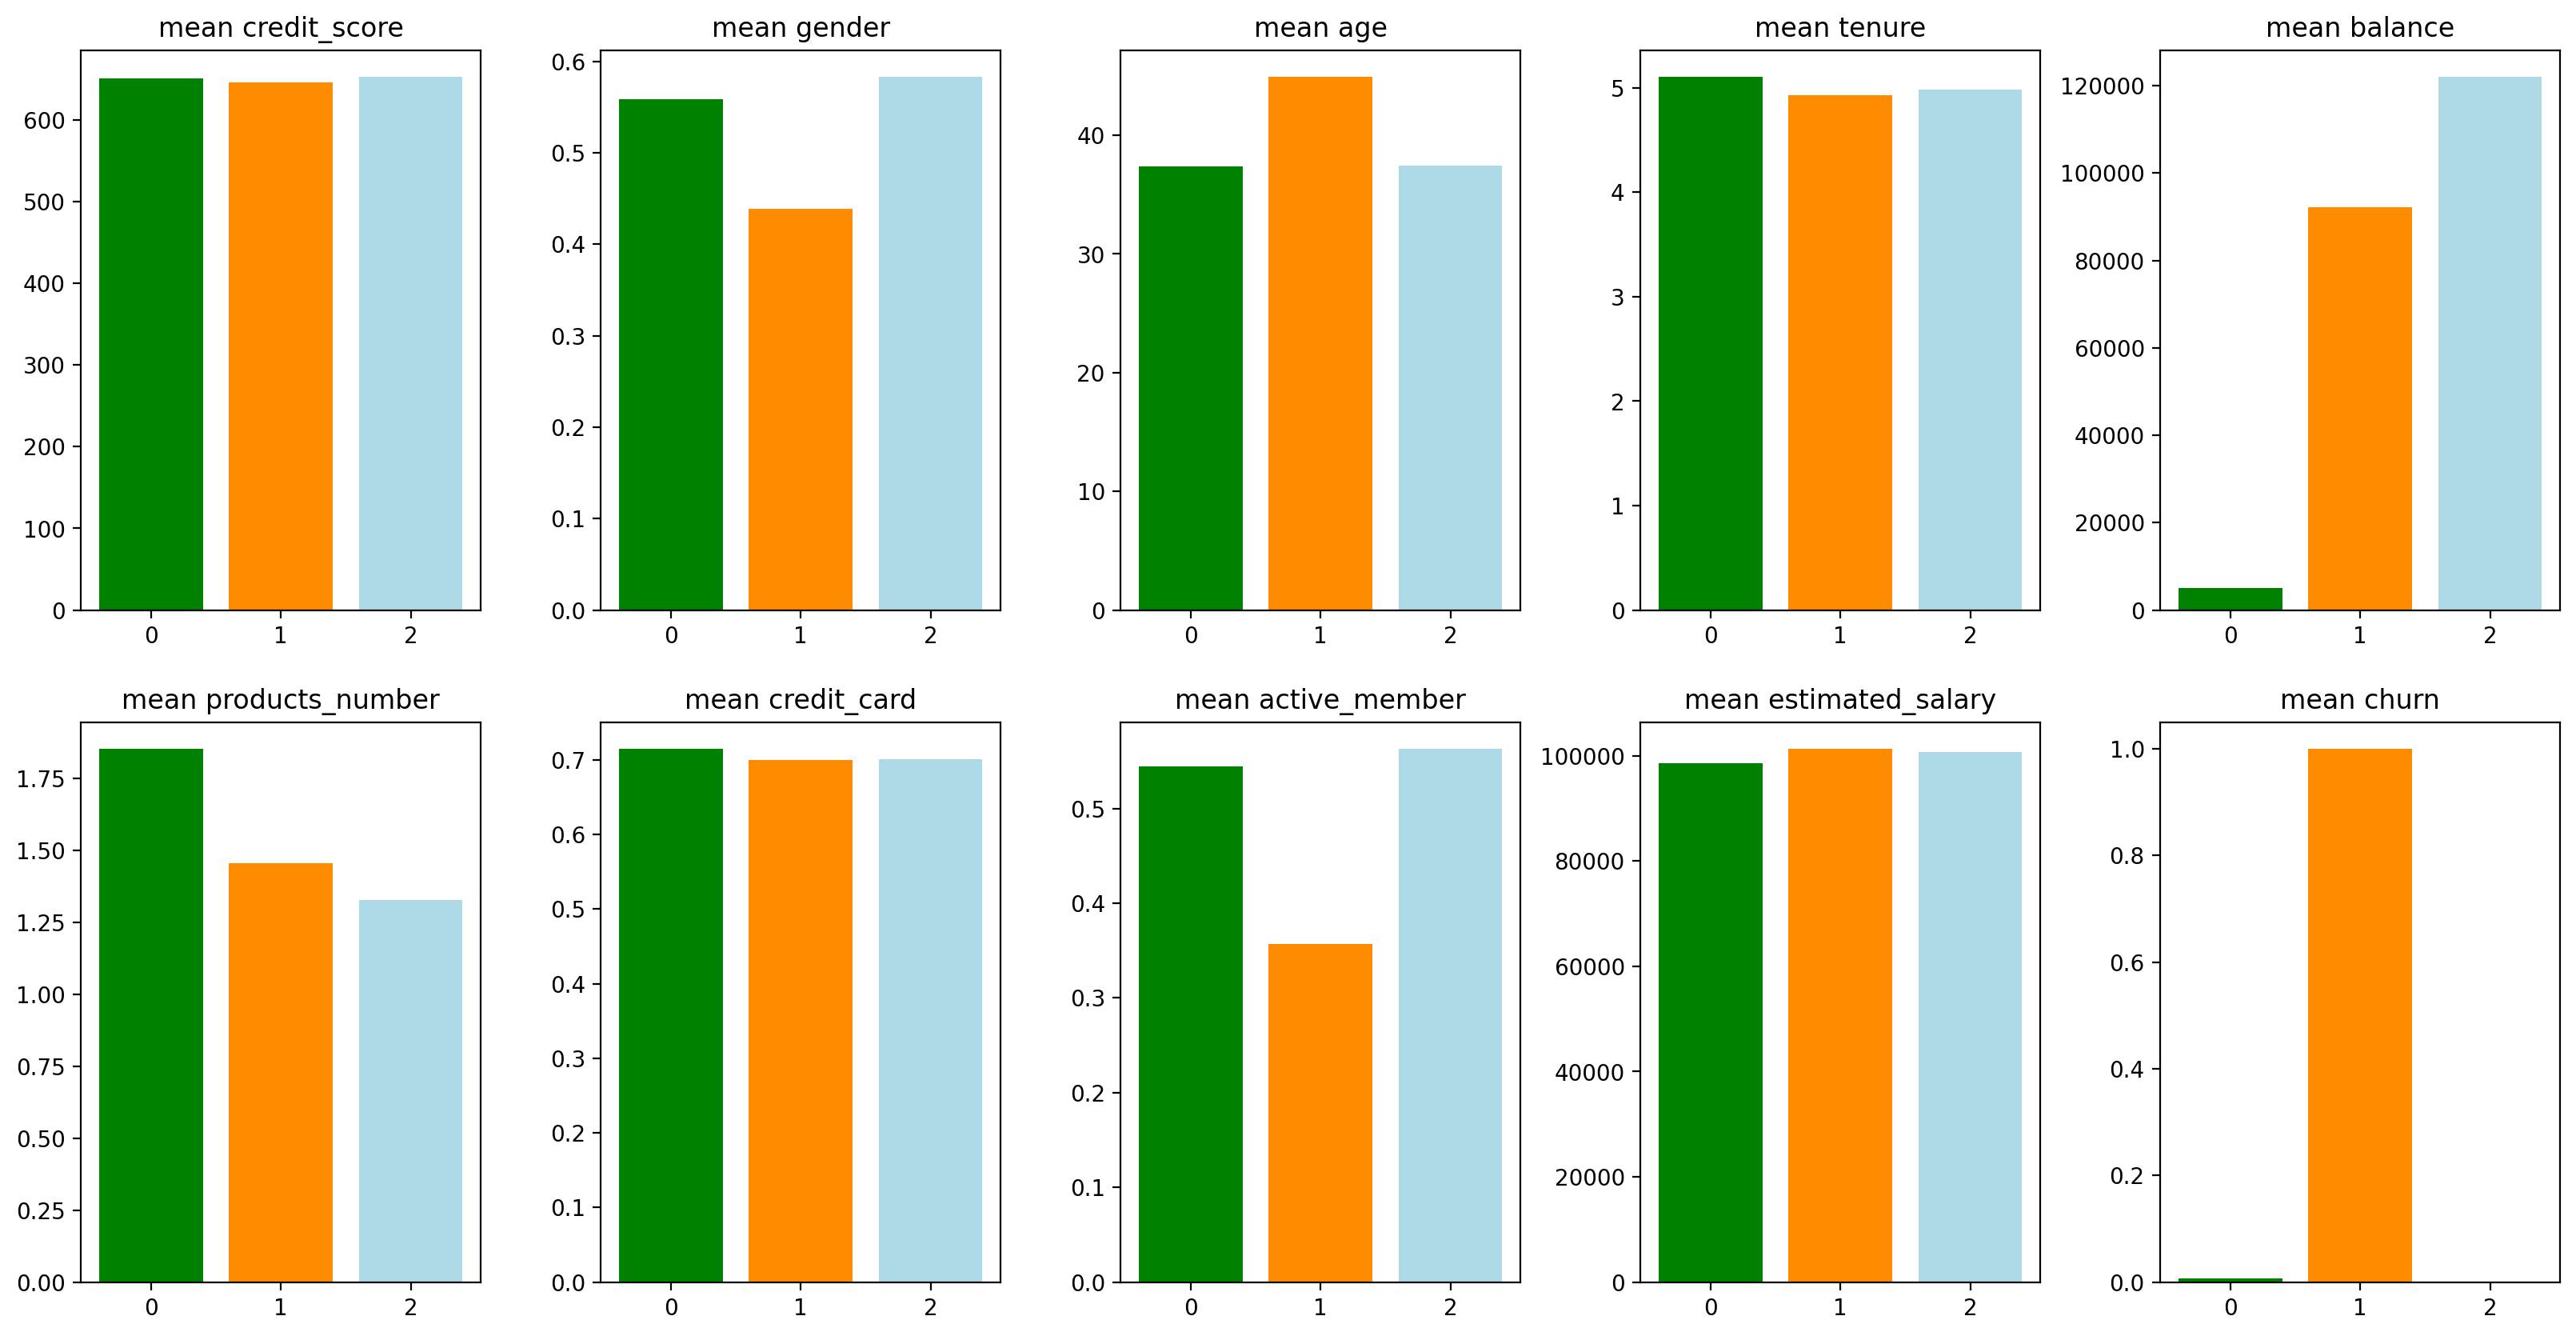

In [112]:
# plotting the results
fig, axes = plt.subplots(2, 5, figsize=(20,10), dpi=200)
plt.subplots_adjust(wspace=.3)
axes = axes.ravel()
colors = {0:'green', 1:'darkorange', 2:'lightblue'}
for i, v in enumerate(clusters.columns[1:]):
    cluster_color = clusters['cluster'].map(colors)
    axes[i].bar(clusters['cluster'], clusters[v], color=cluster_color)
    axes[i].set_title(f'mean {v}')
    axes[i].set_xticks([0,1,2])

<mark><u>**Comment:**</u>

<font color='dodgerblue' size=4><i>
<font color='dodgerblue' size=4><i>* This is interesting in that the clustering algorithm has identified one group as churning customers.  However, there are not many super distinct attributes of this group.  Notably, they are more likely to be female, older, not a member, have a high balance but not the highest balance, and have fewer bank products but not the lowest.
</i></font>

## Splitting Features and Target, Train/Test

### Train Test Split

In [21]:
# checking balance on our target
df['churn'].value_counts()

churn
0    7963
1    2037
Name: count, dtype: int64

<mark><u>**Comment:**</u>

<font color='dodgerblue' size=4><i>
We will stratify our split since we have an unbalanced target
</i></font>

In [22]:
X = df.drop(columns='churn').copy()
y = df['churn'].copy()

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# confirming
print(df.shape, X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(10000, 11) (7500, 10) (2500, 10) (7500,) (2500,)


## Preprocesser

In [24]:
# another look at data types
X.dtypes

credit_score          int64
country              object
gender                int64
age                   int64
tenure                int64
balance             float64
products_number       int64
credit_card           int64
active_member         int64
estimated_salary    float64
dtype: object

In [25]:
## unused code for automating if feature inputs change, will specify columns
##    because some are already ordinal encoded
# cat_selector = make_column_selector(dtype_include='object')
# num_selector = make_column_selector(dtype_include='number')

cat_columns = ['country']
# these are columns that need to be scaled
num_columns = ['credit_score', 'age', 'balance', 'estimated_salary']

cat_preprocessor = OneHotEncoder(sparse=False, handle_unknown='ignore')
num_preprocessor = StandardScaler()

In [26]:
preprocessor = ColumnTransformer(
    [('cat_processor', cat_preprocessor, cat_columns),
     ('num_processor', num_preprocessor, num_columns)
    ],
    remainder='passthrough'
    )
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('cat_processor',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse=False),
                                 ['country']),
                                ('num_processor', StandardScaler(),
                                 ['credit_score', 'age', 'balance',
                                  'estimated_salary'])])

In [27]:
# confirming that the preprocessor is working as expected
preprocessor.fit(X_train)

X_train_proc = preprocessor.transform(X_train)
X_train_proc_df = pd.DataFrame(X_train_proc)
X_train_proc_df.describe()

0       1       2       3       4       5       6       7       8   \
count 7500.00 7500.00 7500.00 7500.00 7500.00 7500.00 7500.00 7500.00 7500.00   
mean     0.50    0.25    0.25   -0.00    0.00   -0.00   -0.00    0.55    5.02   
std      0.50    0.43    0.43    1.00    1.00    1.00    1.00    0.50    2.89   
min      0.00    0.00    0.00   -3.11   -1.99   -1.22   -1.74    0.00    0.00   
25%      0.00    0.00    0.00   -0.69   -0.66   -1.22   -0.86    0.00    3.00   
50%      0.00    0.00    0.00    0.02   -0.19    0.33   -0.01    1.00    5.00   
75%      1.00    0.00    1.00    0.69    0.48    0.82    0.85    1.00    8.00   
max      1.00    1.00    1.00    2.06    5.03    2.34    1.75    1.00   10.00   

           9       10      11  
count 7500.00 7500.00 7500.00  
mean     1.53    0.71    0.52  
std      0.58    0.46    0.50  
min      1.00    0.00    0.00  
25%      1.00    0.00    0.00  
50%      1.00    1.00    1.00  
75%      2.00    1.00    1.00  
max      4.00    1.00    1.00

<mark><u>**Comment:**</u>

<font color='dodgerblue' size=4><i>
Looks good, our numerical columns have been scaled, while our ordinal and binary columns have stayed intact.  Plus we have added the 2 extra columns expected due to One Hot Encoding the 'country' column (3 values for 'country')
</i></font>

## Random Forest Model

<mark><u>**Comment:**</u>

<font color='dodgerblue' size=4><i>
For this particular application, it seems appropriate to **strive for a high recall score** (i.e. we want to catch all customers at high risk of leaving).<br><br>
The assumption baked into this approach is that the costs of a leaving customer are higher than the cost of attempting to retain a customer at risk of churning.
</i></font>

### Base Model

#### Building Model

In [28]:
# building the model pipeline
ranfor_pipe = Pipeline(
    [
        ('preprocessor', preprocessor),
        ('Random Forest Classifier', RandomForestClassifier(random_state=42))
    ]
)
ranfor_pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_processor',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['country']),
                                                 ('num_processor',
                                                  StandardScaler(),
                                                  ['credit_score', 'age',
                                                   'balance',
                                                   'estimated_salary'])])),
                ('Random Forest Classifier',
                 RandomForestClassifier(random_state=42))])

In [29]:
ranfor_pipe.fit(X_train, y_train)

ranfor_pipe.score(X_test, y_test)

0.8648

In [30]:
# Showing that the default 'score' is indeed the accuracy score
accuracy_score(y_test, ranfor_pipe.predict(X_test))

0.8648

In [31]:
# Showing that the default 'score' is indeed the accuracy score
recall_score(y_test, ranfor_pipe.predict(X_test))

0.4675834970530452

<mark><u>**Comment:**</u>

<font color='dodgerblue' size=4><i>
Yikes, this is a terrible recall score (.47).  The accuracy score is decent (.87).  I think this is the result of many more customers that have not churned, and a wide overlap between the two groups.  So the model captures non-churning customers well, and thus elevates the accuracy score.  We'll attempt to improve it through RandomizedSearchCV, but we may have to feature engineer our way to a better dataset, or reframe the possibilities of the model
</i></font>

### Dummy Classifier

In [32]:
dumb_class_pipe = Pipeline(
    [
        ('preprocessor', preprocessor),
        ('dumb classifier', DummyClassifier(strategy='most_frequent'))
    ]
)
dumb_class_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_processor',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['country']),
                                                 ('num_processor',
                                                  StandardScaler(),
                                                  ['credit_score', 'age',
                                                   'balance',
                                                   'estimated_salary'])])),
                ('dumb classifier', DummyClassifier(strategy='most_frequent'))])

In [33]:
display(
    f'Dummy Accuracy: {accuracy_score(y_test, dumb_class_pipe.predict(X_test))}',
    f'Dummy Recall: {recall_score(y_test, dumb_class_pipe.predict(X_test))}',
                                     
)

'Dummy Accuracy: 0.7964'

'Dummy Recall: 0.0'

<mark><u>**Comment:**</u>

<font color='dodgerblue' size=4><i>
Okay, so at least our base model outperforms a dummy classifier
</i></font>

### Randomized Search CV

In [34]:
# getting hyperparameters to tune
ranfor_pipe.get_params();

In [35]:
# these results have been iteratively narrowed in scope to hone in on best model
ranfor_params = {
    'Random Forest Classifier__max_depth': range(15, 26),
    'Random Forest Classifier__max_leaf_nodes': range(120, 141, 2),
    'Random Forest Classifier__n_estimators': range(540, 601, 10),
    'Random Forest Classifier__max_features': range(5, 11)
}

In [36]:
ranfor_random = RandomizedSearchCV(ranfor_pipe, ranfor_params, n_iter=60,
                                  random_state=42, scoring='recall')
ranfor_random.fit(X_train, y_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('cat_processor',
                                                                               OneHotEncoder(handle_unknown='ignore',
                                                                                             sparse=False),
                                                                               ['country']),
                                                                              ('num_processor',
                                                                               StandardScaler(),
                                                                               ['credit_score',
                                                                                'age',
                                                                                'balance',
                                                                                'estimated_salary'])])),
                                             ('Random Forest Classifier',
                                              RandomForestClassifier(random_state=42))]),
                   n_iter=60,
                   param_distributions={'Random Forest Classifier__max_depth': range(15, 26),
                                        'Random Forest Classifier__max_features': range(5, 11),
                                        'Random Forest Classifier__max_leaf_nodes': range(120, 141, 2),
                                        'Random Forest Classifier__n_estimators': range(540, 601, 10)},
                   random_state=42, scoring='recall')

In [37]:
ranfor_df = pd.DataFrame(ranfor_random.cv_results_)

In [38]:
ranfor_df.sort_values('rank_test_score').T

3   \
mean_fit_time                                                                                4.05   
std_fit_time                                                                                 0.02   
mean_score_time                                                                              0.06   
std_score_time                                                                               0.00   
param_Random Forest Classifier__n_estimators                                                  600   
param_Random Forest Classifier__max_leaf_nodes                                                132   
param_Random Forest Classifier__max_features                                                   10   
param_Random Forest Classifier__max_depth                                                      23   
params                                          {'Random Forest Classifier__n_estimators': 600...   
split0_test_score                                                                            0.50   
split1_test_score                                                                            0.42   
split2_test_score                                                                            0.46   
split3_test_score                                                                            0.50   
split4_test_score                                                                            0.47   
mean_test_score                                                                              0.47   
std_test_score                                                                               0.03   
rank_test_score                                                                                 1   

                                                                                               37  \
mean_fit_time                                                                                3.88   
std_fit_time                                                                                 0.01   
mean_score_time                                                                              0.06   
std_score_time                                                                               0.00   
param_Random Forest Classifier__n_estimators                                                  570   
param_Random Forest Classifier__max_leaf_nodes                                                140   
param_Random Forest Classifier__max_features                                                   10   
param_Random Forest Classifier__max_depth                                                      25   
params                                          {'Random Forest Classifier__n_estimators': 570...   
split0_test_score                                                                            0.50   
split1_test_score                                                                            0.42   
split2_test_score                                                                            0.46   
split3_test_score                                                                            0.50   
split4_test_score                                                                            0.46   
mean_test_score                                                                              0.47   
std_test_score                                                                               0.03   
rank_test_score                                                                                 2   

                                                                                               16  \
mean_fit_time                                                                                4.03   
std_fit_time                                                                                 0.06   
mean_score_time                                                                              0.06   
std_score_time                                       

In [39]:
plt.figure(figsize=(10,10), dpi=300)
fig = px.parallel_coordinates(
    ranfor_df.rename(columns=lambda x: x.split('__')[1] if '__' in x else x).apply(
                {'max_depth':lambda x:x,
               'max_leaf_nodes':lambda x:x,    
               'n_estimators':lambda x:x,
                 'max_features':lambda x:x,
                'mean_test_score':lambda x: x}),
    color="mean_test_score",
    color_continuous_scale=px.colors.sequential.Viridis
)

# Show the plot
fig.show();

<Figure size 3000x3000 with 0 Axes>

<mark><u>**Comment:**</u>

<font color='dodgerblue' size=4><i>
This model seems to perform best when max features are set above 7.
</i></font>

### Best Params on Test

In [40]:
recall_score(y_test, ranfor_random.best_estimator_.predict(X_test))

0.4931237721021611

In [41]:
accuracy_score(y_test, ranfor_random.best_estimator_.predict(X_test))

0.87

In [42]:
classification_report(y_test, ranfor_random.best_estimator_.predict(X_test))

'              precision    recall  f1-score   support\n\n           0       0.88      0.97      0.92      1991\n           1       0.79      0.49      0.61       509\n\n    accuracy                           0.87      2500\n   macro avg       0.84      0.73      0.76      2500\nweighted avg       0.86      0.87      0.86      2500\n'

<mark><u>**Comment:**</u>

<font color='dodgerblue' size=4><i>
Okay, tweaking the hyperparameters seems to have made a difference!  Although it's tempting to further tweak the hyperparameters and try to bring the score up, I think the central fact remains that we are far enough away from a usable model that we should try feature engineering.
</i></font>

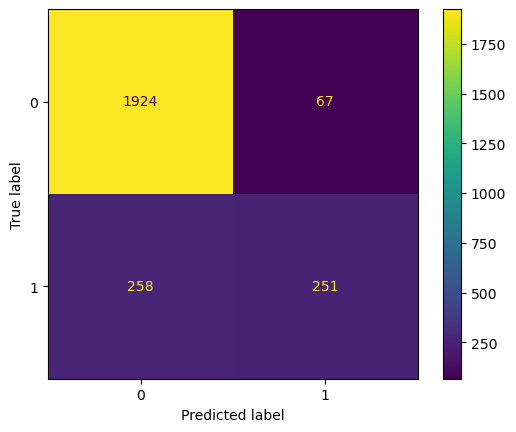

In [43]:
ConfusionMatrixDisplay.from_estimator(ranfor_random.best_estimator_, 
                                      X_test, y_test)

<mark><u>**Comment:**</u>

<font color='dodgerblue' size=4><i>
So as things stand now, we really can't do better than random chance at predicting churn.
</i></font>

## Feature Engineering Sandbox

<font color='dodgerblue' size=4>
Before using different models to generalize the data, I'm going to see if we can increase model performance via feature engineering
</font>

In [44]:
# saving a new df to work with
df_rev = df.copy()

In [45]:
df_rev.sample(5)

credit_score country  gender  age  tenure   balance  products_number  \
5088           543  France       1   42       4  89838.71                3   
6362           629   Spain       1   34       8      0.00                2   
5615           520  France       0   29       8  95947.76                1   
9631           526  France       0   37       5  53573.18                1   
3845           712  France       1   34       8 114088.32                1   

      credit_card  active_member  estimated_salary  churn  
5088            1              0          85983.54      1  
6362            1              1         180595.02      0  
5615            1              0           4696.44      0  
9631            1              0          62830.97      0  
3845            1              0          92794.61      0

In [46]:
# another look at our pairplot to see what associations we can make

#sns.pairplot(data=df, hue='churn');

### Balance

In [47]:
# new column 'has_balance' for customers with no balance
df_rev['has_balance'] = df['balance'].apply(lambda x: 1 if x > 0 else 0)

# confirming
df_rev.sample(5)

credit_score  country  gender  age  tenure   balance  products_number  \
1129           669   France       0   35       7      0.00                1   
9196           794    Spain       0   37       9      0.00                2   
9233           543   France       0   31       4 138317.94                1   
3435           676  Germany       0   34       4  89437.03                1   
6476           739   France       1   40       4      0.00                2   

      credit_card  active_member  estimated_salary  churn  has_balance  
1129            1              1          49108.23      1            0  
9196            1              0          68008.85      0            0  
9233            0              0          61843.73      0            1  
3435            1              1         189540.95      0            1  
6476            0              0         173321.65      0            0

### Dropping 'estimated salary', 'tenure', 'balance'

<font color='dodgerblue' size=4>
I suspect 'tenure' may be a noisy column.  I'm going to also try dropping 'estimated_salary' based on the distribution of values found in the pairplot.  Lastly, I will try dropping 'balance' now that we have a 'has_balance' column.
</font>

In [48]:
# I see no clear trend in tenure helping to predict churn.
# avg 'churn' gives proportion of churned to non-churned in group.
df.groupby('tenure')['churn'].mean()

tenure
0    0.23
1    0.22
2    0.19
3    0.21
4    0.21
5    0.21
6    0.20
7    0.17
8    0.19
9    0.22
10   0.21
Name: churn, dtype: float64

In [49]:
# It looks to me that these two columns are just adding noise to the model
# Trying to drop 'balance' as well now that we have the 'has_balance' column
df_rev = df_rev.drop(columns=['estimated_salary', 'tenure', 'balance']).copy()

df_rev.sample(3)

credit_score country  gender  age  products_number  credit_card  \
6356           647  France       1   43                2            1   
7260           773  France       0   41                1            1   
3039           829   Spain       0   26                2            1   

      active_member  churn  has_balance  
6356              1      0            0  
7260              1      0            1  
3039              1      0            1

### Train test on Feature Engineered data

In [50]:
X_rev = df_rev.drop(columns='churn')
y_rev = df_rev['churn']

X_train_rev, X_test_rev, y_train_rev, y_test_rev = train_test_split(X_rev, y_rev, random_state=0)

In [51]:
cat_columns2 = ['country']
num_columns2 = ['credit_score', 'age', 'products_number']

preprocessor2 = make_column_transformer((OneHotEncoder(sparse=False, handle_unknown='ignore'), cat_columns2),
                                       (StandardScaler(), num_columns2))

In [52]:
ranfor_pipe2 = make_pipeline(preprocessor2, RandomForestClassifier(random_state=0))

In [53]:
ranfor_pipe2.fit(X_train_rev, y_train_rev)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['country']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['credit_score', 'age',
                                                   'products_number'])])),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=0))])

In [54]:
display(f'Accuracy score: \
        {accuracy_score(y_test_rev, ranfor_pipe2.predict(X_test_rev))}',
        f'Recall score: \
        {recall_score(y_test_rev, ranfor_pipe2.predict(X_test_rev))}')
        

'Accuracy score:         0.7964'

'Recall score:         0.47544204322200395'

In [55]:
classification_report(y_test_rev, ranfor_pipe2.predict(X_test_rev))

'              precision    recall  f1-score   support\n\n           0       0.87      0.88      0.87      1991\n           1       0.50      0.48      0.49       509\n\n    accuracy                           0.80      2500\n   macro avg       0.68      0.68      0.68      2500\nweighted avg       0.79      0.80      0.79      2500\n'

<mark><u>**Comment:**</u>

<font color='dodgerblue' size=4><i>
So far I'm skeptical we can feature engineer our way to a much higher recall score.  I think our main problem is too much overlap in churn scores.
</i></font>

## To Do
<mark><font size=4> * build function, itertools makes all possible combinations n >= 2 of features, cross validate models, score them, dump the results in a dataframe
    
<mark><font size=4> * Apply boosted models, re-read sklearn docs/MOOC for hyperparameter tuning guidance.

<mark><font size=4> *Implement cross validation and nested cross validation